In [4]:
# general imports
import numpy as np
from typing import List, Optional, Tuple, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import itertools
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel
import unidecode
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from sklearn import preprocessing
from statsmodels.formula.api import ols

In [5]:
def average(lst):
    """
    A function that finds the average of a list of items.
    """
    return sum(lst) / len(lst)

def removeNanValues(column, df) -> None:
    """
    A function that remove NaN values from a specific row in a dataframe.
    
    :param column: The column to be considered.
    :param character: The dataframe to be used.
    """
    # replace any empty strings in the long name column with np.nan objects
    df[column].replace('', np.nan, inplace=True)
    df[column].replace(r'^\s*$', np.nan, regex=True)
    # drop the null values
    df.dropna(subset=[column], inplace=True)

def isDarkerSkin(value):
    if value == 'Darker skin tone':
        return True
    else: return False
    

def isDarkerSkinBinary(value):
    if value == 'Darker skin tone':
        return 1
    else: return 0
    
def isPhysicalPosition(value):
    if value == 'physical':
        return 1
    else: return 0
    

def isTacticalPosition(value):
    if value == 'tactical':
        return 1
    else: return 0
    
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### RQ2

#### Getting twitter data

In [6]:
twitter_df = pd.read_csv('data/temp/processed_data/twitter/twitter_player_sentiment.csv')
twitter_df.head()

ID                                            comment  \
0  896158015572672512  Giroud staying will prove vital to our season ...   
1  896157035623981056            Rambo / Giroud subbed on #Wengerin #afc   
2  896154976296108033  Giroud honestly have my kids you beautiful hum...   
3  896154848407633920  Holy shit just watched the Arsenal game.   Wha...   
4  896154594840985600  I love @_OlivierGiroud_ the handsome bearded b...   

                        date            user team_home       team_away  \
0  2017-08-11 23:54:55+00:00  bradleyleggett   ARSENAL  LEICESTER CITY   
1  2017-08-11 23:51:01+00:00    Gunnerball66   ARSENAL  LEICESTER CITY   
2  2017-08-11 23:42:50+00:00     jhollister_   ARSENAL  LEICESTER CITY   
3  2017-08-11 23:42:20+00:00      gunnerbeaz   ARSENAL  LEICESTER CITY   
4  2017-08-11 23:41:19+00:00     Thegooner27   ARSENAL  LEICESTER CITY   

              competition season person_name player_long_name  ...  \
0  English Premier League  17/18      Giroud   Olivier Giroud  ...   
1  English Premier League  17/18      Giroud   Olivier Giroud  ...   
2  English Premier League  17/18      Giroud   Olivier Giroud  ...   
3  English Premier League  17/18      Giroud   Olivier Giroud  ...   
4  English Premier League  17/18      Giroud   Olivier Giroud  ...   

                                        player_image  \
0  https://cdn.soccerwiki.org/images/player/15177...   
1  https://cdn.soccerwiki.org/images/player/15177...   
2  https://cdn.soccerwiki.org/images/player/15177...   
3  https://cdn.soccerwiki.org/images/player/15177...   
4  https://cdn.soccerwiki.org/images/player/15177...   

   player_soccer_wiki_color player_position player_position_description  \
0                     White            F(C)                  TARGET MAN   
1                     White            F(C)                  TARGET MAN   
2                     White            F(C)                  TARGET MAN   
3                     White            F(C)                  TARGET MAN   
4                     White            F(C)                  TARGET MAN   

  player_rating player_age  player_whoscored_position  match_score  \
0          7.53         35                        Sub        3-Apr   
1          7.53         35                        Sub        3-Apr   
2          7.53         35                        Sub        3-Apr   
3          7.53         35                        Sub        3-Apr   
4          7.53         35                        Sub        3-Apr   

  vader_sentiment_score vader_sentiment_label  
0                0.4588              Positive  
1                0.0000               Neutral  
2                0.7845              Positive  
3               -0.5574              Negative  
4                0.5994              Positive  

[5 rows x 22 columns]

#### Summary statistics

In [7]:
positive = twitter_df.loc[twitter_df.vader_sentiment_label == 'Positive']
print('Positive comments')
print(len(positive))
negative = twitter_df.loc[twitter_df.vader_sentiment_label == 'Negative']
print('Negative comments')
print(len(negative))
df1 = positive.groupby(['player_id'])['player_id'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
print(df1)
print(twitter_df.loc[twitter_df.player_id == 49590]['player_long_name'].head(1))

df2 = negative.groupby(['player_id'])['player_id'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
print(df2)
print(twitter_df.loc[twitter_df.player_id == 49590]['player_long_name'].head(1))


Positive comments
22172
Negative comments
8824
     player_id  count
155      49590   1527
179      53822    999
191      58616    832
39       15177    707
133      45273    626
286    Harry Kane
Name: player_long_name, dtype: object
     player_id  count
138      49590    675
120      45273    309
158      53822    308
169      58616    302
134      47159    252
286    Harry Kane
Name: player_long_name, dtype: object


In [8]:
group_lighter = ['White','Pale','Olive']
group_darker = ['Black','Brown','Dark brown']
twitter_df['grouped_skin_color'] = ['Lighter skin tone' if skin_color in group_lighter 
                                     else ('Darker skin tone' if skin_color in group_darker else '') 
                                     for skin_color in twitter_df.player_soccer_wiki_color]

removeNanValues('grouped_skin_color', twitter_df)
    
physical_positions = ['TARGET MAN','FINISHER','WINGBACK','GENERAL FORWARD','WINGER']
tactical_positions = ['BOX-TO-BOX MIDFIELDER','BALL-WINNING MIDFIELDER','PLAYMAKER','KEEPER','GENERAL MIDFIELDER','DEEP-LYING PLAYMAKER']

twitter_df['player_position_group'] = ['physical' if player_position in physical_positions 
                                     else ('tactical' if player_position in tactical_positions else '') 
                                     for player_position in twitter_df.player_position_description]

removeNanValues('player_position_group', twitter_df)

In [9]:
twitter_df['is_darker_skin'] = twitter_df.grouped_skin_color.apply(isDarkerSkin)
twitter_df['is_darker_skin_binary'] = twitter_df.grouped_skin_color.apply(isDarkerSkinBinary)

twitter_df['is_physical_position'] = twitter_df.player_position_group.apply(isPhysicalPosition)
twitter_df['is_tactical_position'] = twitter_df.player_position_group.apply(isTacticalPosition)

#### Preparing players dataset.

In [10]:
def get_players_df(reddit_data):
    players_df = pd.DataFrame(columns=['id', 'skin_color', 'is_darker_skin', 'is_darker_skin_binary','age', 'rating_average',
                                   'visibility', 'player_position_group','is_physical_position', 'is_tactical_position',
                                  'prop_positive', 'prop_negative', 'average_negativity', 'average_positivity', 'sentiment_score'])
    
    player_ids = reddit_data.player_id.unique()
    total = len(reddit_data)
    index = 0
    for player_id in player_ids:
        avg_negative = 0
        avg_positive = 0
        quartile_negative = 0
        quartile_positive = 0
        data = reddit_data.loc[reddit_data.player_id == player_id]
        positive_data = data.loc[data.vader_sentiment_label == 'Positive']['vader_sentiment_score'].values
        negative_data = data.loc[data.vader_sentiment_label == 'Negative']['vader_sentiment_score'].values
        
        if (len(positive_data)):
            avg_positive = average(positive_data)
            quartile_positive = data.loc[data.vader_sentiment_label == 'Positive']['vader_sentiment_score'].quantile(0.9)
            
        if (len(negative_data)):
            avg_negative = average(negative_data)
            quartile_negative = data.loc[data.vader_sentiment_label == 'Negative']['vader_sentiment_score'].quantile(0.1)
            
        prop_positive = len(data.loc[data.vader_sentiment_label == 'Positive']) / len(data)
        prop_negative = len(data.loc[data.vader_sentiment_label == 'Negative']) / len(data)
        
        
        new_data = pd.DataFrame({'id': player_id, 
                                 'skin_color': data.grouped_skin_color.iloc[0],
                                 'is_darker_skin': data.is_darker_skin.iloc[0],
                                 'is_darker_skin_binary': data.is_darker_skin_binary.iloc[0],
                                 'age': data.player_age.iloc[0],
                                 'rating_average': average(data.player_rating.values),
                                 'number_comments': len(data),
                                 'visibility': len(data)/total,
                                 'player_position_group': data.player_position_group.iloc[0],
                                 'is_physical_position': data.is_physical_position.iloc[0],
                                 'is_tactical_position': data.is_tactical_position.iloc[0],
                                 'prop_positive': prop_positive,
                                 'prop_negative': prop_negative,
                                'average_negativity': avg_negative,
                                'average_positivity': avg_positive,
                                 'median': data.vader_sentiment_score.median(),
                                'quartile_positive': quartile_positive,
                                'quartile_negative': quartile_negative},
                                index = [index])
        players_df = pd.concat([players_df, new_data])
        index = index + 1
    
    players_df['id'] =  pd.to_numeric(players_df['id'])
    players_df['rating_average'] = pd.to_numeric(players_df['rating_average'])
    players_df['age'] = pd.to_numeric(players_df['age'])
    players_df['visibility'] = pd.to_numeric(players_df['visibility'])
    players_df['prop_positive'] = pd.to_numeric(players_df['prop_positive'])
    players_df['prop_negative'] = pd.to_numeric(players_df['prop_negative'])
    players_df['average_positivity'] = pd.to_numeric(players_df['average_positivity'])
    players_df['average_negativity'] = pd.to_numeric(players_df['average_negativity'])
    players_df['quartile_positive'] = pd.to_numeric(players_df['quartile_positive'])
    players_df['quartile_negative'] = pd.to_numeric(players_df['quartile_negative'])
    players_df['median'] = pd.to_numeric(players_df['median'])
    players_df['is_darker_skin_binary'] = pd.to_numeric(players_df['is_darker_skin_binary'])
    players_df['is_physical_position'] = pd.to_numeric(players_df['is_physical_position'])
    players_df['is_tactical_position'] = pd.to_numeric(players_df['is_tactical_position'])
    players_df['number_comments'] = players_df['number_comments'].astype(int)
        
    players_df['is_darker_skin'] = players_df['is_darker_skin'].astype('bool')
    
    return players_df

In [14]:
df = get_players_df(twitter_df)
df.head()

id         skin_color  is_darker_skin  is_darker_skin_binary  age  \
0  15177  Lighter skin tone           False                      0   35   
1  53822  Lighter skin tone           False                      0   35   
2  46443  Lighter skin tone           False                      0   29   
3  28700  Lighter skin tone           False                      0   31   
4  58616  Lighter skin tone           False                      0   31   

   rating_average  visibility player_position_group  is_physical_position  \
0        7.839968    0.036869              physical                     1   
1        7.400393    0.061106              physical                     1   
2        6.898759    0.009765              tactical                     0   
3        7.447259    0.019809              tactical                     0   
4        7.841872    0.053905              physical                     1   

   is_tactical_position  prop_positive  prop_negative  average_negativity  \
0                     0       0.446903       0.091656           -0.621101   
1                     0       0.381007       0.117468           -0.604017   
2                     1       0.324582       0.198091           -0.617684   
3                     1       0.361176       0.147059           -0.608306   
4                     0       0.359706       0.130566           -0.598586   

   average_positivity sentiment_score  number_comments  median  \
0            0.693771             NaN             1582  0.2732   
1            0.675288             NaN             2622  0.0258   
2            0.675120             NaN              419  0.0000   
3            0.666774             NaN              850  0.0000   
4            0.653628             NaN             2313  0.0000   

   quartile_positive  quartile_negative  
0            0.92170           -0.81560  
1            0.90396           -0.80501  
2            0.90380           -0.81828  
3            0.90092           -0.78182  
4            0.87435           -0.82250

In [15]:
print('Players with darker skin tone playing in physical positions',len(df.loc[(df.is_darker_skin == True) & (df.player_position_group == 'physical')]))
print('Players with darker skin tone playing in tactical positions',len(df.loc[(df.is_darker_skin == True) & (df.player_position_group == 'tactical')]))

print('Players with lighter skin tone playing in physical positions',len(df.loc[(df.is_darker_skin == False) & (df.player_position_group == 'physical')]))
print('Players with lighter skin tone playing in tactical positions', len(df.loc[(df.is_darker_skin == False) & (df.player_position_group == 'tactical')]))

df.to_csv('data/analysis/players_twitter.csv')

Players with darker skin tone playing in physical positions 50
Players with darker skin tone playing in tactical positions 23
Players with lighter skin tone playing in physical positions 59
Players with lighter skin tone playing in tactical positions 84


#### Correlation between age and quartile negative/positive

In [16]:
from scipy.stats import pearsonr

print(pearsonr(df['age'], df['quartile_negative']))
print(pearsonr(df['age'], df['quartile_positive']))

(-0.09006373316270444, 0.1872821187558092)
(-0.018213940440274027, 0.7901175462616413)


#### Normalization of variables

In [17]:
df['age'] = NormalizeData(df.age.values)
df['rating_average'] = NormalizeData(df.rating_average.values)
df['visibility'] = np.log2(df.visibility)

#### Linear Regression Models

In [38]:
reg = ols("quartile_positive ~ is_darker_skin_binary + age + rating_average + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_quartile_positive.html","w")
file.write(stargazer.render_latex())
file.close()

In [39]:
reg = ols("quartile_negative ~ is_darker_skin_binary + age + rating_average + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_quartile_negative.html","w")
file.write(stargazer.render_latex())
file.close()

#### Multicollinearity

In [40]:
data = df[['is_darker_skin_binary','age','rating_average', 'visibility', 'is_physical_position','quartile_positive','quartile_negative']]

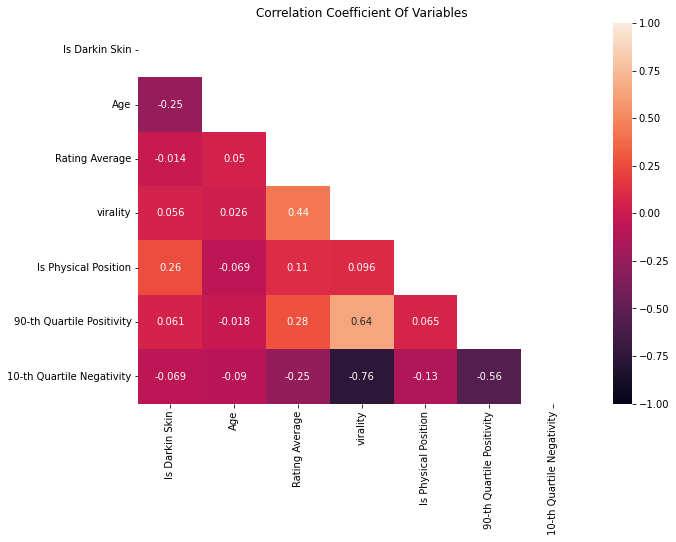

In [41]:
# set figure size
plt.figure(figsize=(10,7))

data = data.rename(columns={'is_darker_skin_binary': 'Is Darkin Skin', 'age': 'Age','rating_average':'Rating Average',
                          'is_physical_position':'Is Physical Position', 'visibility': 'virality', 
                            'quartile_negative': '10-th Quartile Negativity', 'quartile_positive': '90-th Quartile Positivity'})
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# generate heatmap
sns.heatmap(data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Variables')
plt.show()

### RQ3

#### Getting and preparing the data

In [18]:
twitter_df = pd.read_csv('data/temp/processed_data/twitter/twitter_supersenses.csv')

group_lighter = ['White','Pale','Olive']
group_darker = ['Black','Brown','Dark brown']
twitter_df['grouped_skin_color'] = ['Lighter skin tone' if skin_color in group_lighter 
                                     else ('Darker skin tone' if skin_color in group_darker else '') 
                                     for skin_color in twitter_df.player_soccer_wiki_color]

removeNanValues('grouped_skin_color', twitter_df)
    
physical_positions = ['TARGET MAN','FINISHER','WINGBACK','GENERAL FORWARD','WINGER']
tactical_positions = ['BOX-TO-BOX MIDFIELDER','BALL-WINNING MIDFIELDER','PLAYMAKER','KEEPER','GENERAL MIDFIELDER','DEEP-LYING PLAYMAKER']

twitter_df['player_position_group'] = ['physical' if player_position in physical_positions 
                                     else ('tactical' if player_position in tactical_positions else '') 
                                     for player_position in twitter_df.player_position_description]

removeNanValues('player_position_group', twitter_df)

twitter_df['is_darker_skin'] = twitter_df.grouped_skin_color.apply(isDarkerSkin)
twitter_df['is_darker_skin_binary'] = twitter_df.grouped_skin_color.apply(isDarkerSkinBinary)

twitter_df['is_physical_position'] = twitter_df.player_position_group.apply(isPhysicalPosition)
twitter_df['is_tactical_position'] = twitter_df.player_position_group.apply(isTacticalPosition)

physical_categories = ['TEMPORAL', 'BODY']
tactical_categories = ['BEHAVIOR', 'MIND']

#### Define the category of the comment

In [19]:
for index, row2 in twitter_df.iterrows():
    physical_comments = 0
    tactical_comments = 0
    category_0, category_1, category_2 = str(row2.category_0).strip(), str(row2.category_1).strip(),str(row2.category_2).strip()
    if category_0 in physical_categories or category_1 in physical_categories or category_2 in physical_categories in physical_categories:
        physical_comments += 1
    if category_0 in tactical_categories or category_1 in tactical_categories or category_2 in tactical_categories in tactical_categories:
        tactical_comments += 1
    
    twitter_df.loc[index, 'comment_category'] = 'Physical' if physical_comments > tactical_comments else 'Tactical'

#### Investigating the relationship between sentiment score and category group

In [20]:
data1 = twitter_df.loc[(twitter_df.comment_category == 'Physical')]['vader_sentiment_score'] 
data2 = twitter_df.loc[(twitter_df.comment_category == 'Tactical')]['vader_sentiment_score'] 

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'Sentiment Score')]

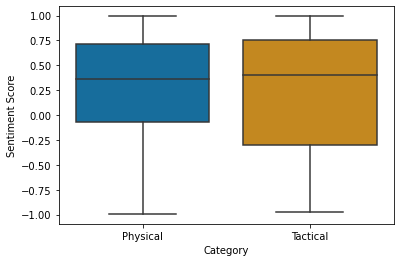

In [21]:
sns.boxplot(y='vader_sentiment_score', x='comment_category', 
                 data=twitter_df, 
                 palette="colorblind").set(
    xlabel='Category', 
    ylabel='Sentiment Score'
)

In [22]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=twitter_df, res_var='value', anova_model='vader_sentiment_score ~ C(comment_category)')
res.anova_summary

df       sum_sq   mean_sq         F    PR(>F)
C(comment_category)     1.0     1.951476  1.951476  6.459454  0.011051
Residual             9976.0  3013.866234  0.302112       NaN       NaN

#### Get Has Physical/Tactical Comments and Total Physical/Tactical Comments

In [23]:
def get_info_comments(players_df, twitter_df):
    for index, row in players_df.iterrows():
        #get the list of comments targeting the player
        comments = twitter_df.loc[twitter_df.player_id == row.id]
        physical_comments = 0
        tactical_comments = 0
        for index2, row2 in comments.iterrows():
            comment_category = str(row2.comment_category)
            if comment_category == 'Physical':
                physical_comments += 1
            else:
                tactical_comments += 1
        
        players_df.loc[index, 'has_physical_comments'] = 1 if physical_comments > 0 else 0
        players_df.loc[index, 'has_tactical_comments'] = 1 if tactical_comments > 0 else 0
        players_df.loc[index, 'total_physical_comments'] = physical_comments 
        players_df.loc[index, 'total_tactical_comments'] = tactical_comments 
    return players_df

In [24]:
players_df = get_players_df(twitter_df)

In [25]:
df = get_info_comments(players_df, twitter_df)

df['age'] = NormalizeData(df.age.values)
df['rating_average'] = NormalizeData(df.rating_average.values)
df['visibility'] = np.log2(df.visibility)
df['total_physical_comments'] = NormalizeData(df.total_physical_comments.values)
df['total_tactical_comments'] = NormalizeData(df.total_tactical_comments.values)

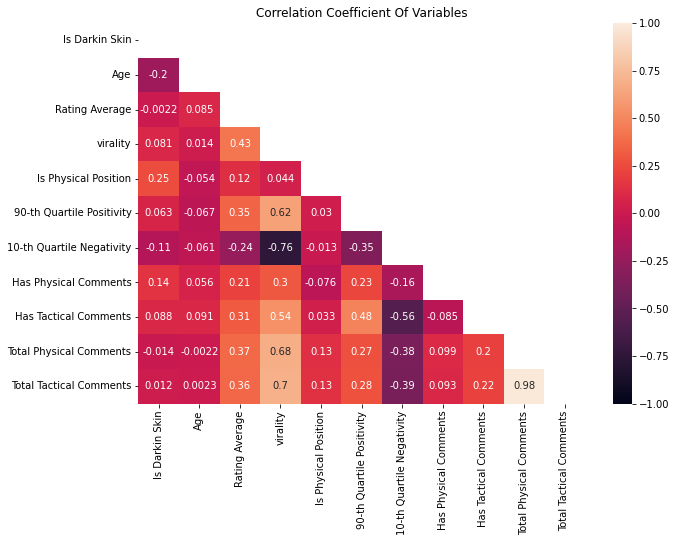

In [26]:
data = df[['is_darker_skin_binary','age','rating_average', 'visibility', 'is_physical_position','quartile_positive','quartile_negative','has_physical_comments','has_tactical_comments','total_physical_comments','total_tactical_comments']]

# set figure size
plt.figure(figsize=(10,7))

data = data.rename(columns={'is_darker_skin_binary': 'Is Darkin Skin', 'age': 'Age','rating_average':'Rating Average',
                          'is_physical_position':'Is Physical Position', 'visibility': 'virality', 
                            'quartile_negative': '10-th Quartile Negativity', 'quartile_positive': '90-th Quartile Positivity',
                           'has_physical_comments':'Has Physical Comments','has_tactical_comments':'Has Tactical Comments',
                           'total_physical_comments':'Total Physical Comments','total_tactical_comments':'Total Tactical Comments'})
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# generate heatmap
sns.heatmap(data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Variables')
plt.show()

#### Linear regression models

In [27]:
reg = ols("has_physical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_all_physical.html","w")
file.write(stargazer.render_latex())
file.close()

reg = ols("has_tactical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_all_tactical.html","w")
file.write(stargazer.render_latex())
file.close()

In [28]:
data_physical = df.loc[df.has_physical_comments == 1]
data_tactical = df.loc[df.has_tactical_comments == 1]

In [29]:
reg = ols("total_physical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = data_physical).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_all_physical_prop.html","w")
file.write(stargazer.render_latex())
file.close()

reg = ols("total_tactical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = data_tactical).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_all_tactical_prop.html","w")
file.write(stargazer.render_latex())
file.close()

#### Considering negative comments

In [30]:
twitter_df = twitter_df.loc[twitter_df.vader_sentiment_label == 'Negative']

In [32]:
players_df = get_players_df(twitter_df)
df = get_info_comments(players_df, twitter_df)
df['age'] = NormalizeData(df.age.values)
df['rating_average'] = NormalizeData(df.rating_average.values)
df['visibility'] = np.log2(df.visibility)
df['total_physical_comments'] = NormalizeData(df.total_physical_comments.values)
df['total_tactical_comments'] = NormalizeData(df.total_tactical_comments.values)

In [33]:
reg = ols("has_physical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_negative_physical.html","w")
file.write(stargazer.render_latex())
file.close()

reg = ols("has_tactical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = df).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_negative_tactical.html","w")
file.write(stargazer.render_latex())
file.close()

In [34]:
data_physical = df.loc[df.has_physical_comments == 1]
data_tactical = df.loc[df.has_tactical_comments == 1]

In [35]:
reg = ols("total_physical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = data_physical).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_negative_physical_prop.html","w")
file.write(stargazer.render_latex())
file.close()

reg = ols("total_tactical_comments ~ is_darker_skin_binary + visibility + is_physical_position", data = data_tactical).fit(cov_type = 'HC3')
stargazer = Stargazer([reg])

file = open("data/analysis/twitter_negative_tactical_prop.html","w")
file.write(stargazer.render_latex())
file.close()